In [57]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [58]:
df = pd.read_csv('output.csv')

In [59]:
df.head()

,round,embb_req,embb_giv,embb_user,embb_true,urllc_req,urllc_giv,urllc_user,urllc_true,miot_req,...,miot_true,mmtc_req,mmtc_giv,mmtc_user,mmtc_true,voice_req,voice_giv,voice_user,voice_true,band_rem
0,0,0,0,78,0,0,0,70,0,0,...,0,0,0,49,0,0,0,44,0,20000000000
1,1,30430335704,7582746265,80,18681427593,272022453,272022453,73,272022453,163725699,...,163725699,244966402,244966402,50,244966402,265362482,44000000,46,195132888,11692539181
2,2,23352644918,6690681473,74,19349400057,13276849,13276849,32,13276849,24797817,...,24797817,7242244,7242244,19,7242244,234675281,46000000,46,227932470,13218001617
3,3,18061487005,5731075885,129,18059737506,123470820,123470820,95,123470820,66430352,...,66430352,84617441,84617441,65,84617441,188675281,46000000,80,184409004,13948405502
4,4,38764439780,8211207422,179,18571999052,282002068,279260928,134,279990151,163262413,...,163262413,207960005,207960005,106,207960005,357005892,80000000,112,209070894,11058309232


In [60]:
TRAIN_SPLIT = 30

In [61]:
tf.random.set_seed(13)

In [26]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x131b34690>,
      dtype=object)

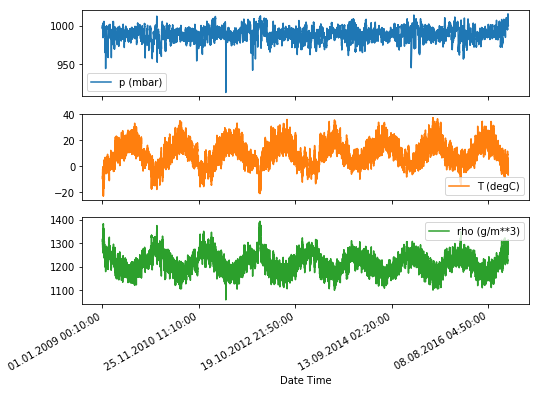

In [28]:
features.plot(subplots=True)

In [44]:
dataset = features.values
print(dataset[:, 0:2])
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

[[996.52  -8.02]
 [996.57  -8.41]
 [996.53  -8.51]
 ...
 [999.82  -3.16]
 [999.81  -4.23]
 [999.82  -4.82]]


In [30]:
dataset = (dataset-data_mean)/data_std

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [45]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0:2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0:2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [46]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [47]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [48]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [49]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [50]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 70s 352ms/step - loss: 497.3198 - val_loss: 496.6551
Epoch 2/10
200/200 [==============================] - 56s 280ms/step - loss: 495.8464 - val_loss: 495.4521
Epoch 3/10
200/200 [==============================] - 46s 232ms/step - loss: 496.3381 - val_loss: 494.3838
Epoch 4/10
200/200 [==============================] - 71s 355ms/step - loss: 495.0140 - val_loss: 493.4338
Epoch 5/10
200/200 [==============================] - 49s 246ms/step - loss: 493.6071 - val_loss: 492.6513
Epoch 6/10
200/200 [==============================] - 54s 272ms/step - loss: 492.1391 - val_loss: 492.0439
Epoch 7/10
200/200 [==============================] - 61s 306ms/step - loss: 491.9481 - val_loss: 491.5428
Epoch 8/10
200/200 [==============================] - 76s 382ms/step - loss: 491.5427 - val_loss: 491.1528
Epoch 9/10
200/200 [==============================] - 59s 297ms/step - loss: 492.1662 - val_loss: 490

In [51]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

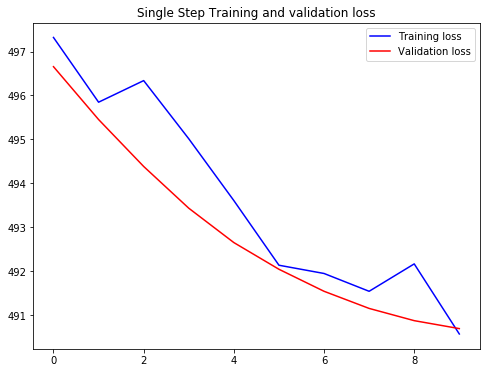

In [52]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

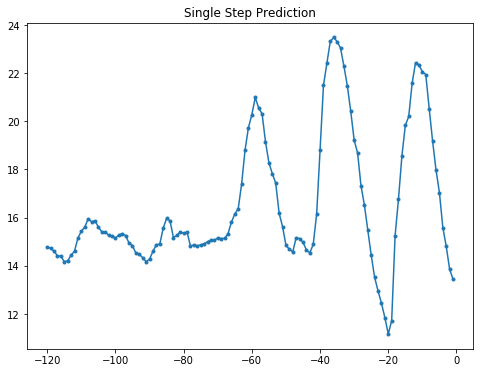

In [54]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()